In [ ]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display


In [ ]:
!pip 3 install pydub
!pip install pydub

ERROR: unknown command "3"
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D,MaxPooling2D ,Flatten, Reshape

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib.backends.backend_agg import FigureCanvasAgg
from pydub import AudioSegment
import torch
import tensorflow as tf
import torch.nn as nn

In [ ]:
!pip install pydot
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/mdeff/fma.git
%cd fma

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cp -r /content/drive/MyDrive/utils.py .

In [ ]:
!pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import utils

In [ ]:
AUDIO_DIR = os.environ.get('AUDIO_DIR')


In [ ]:
tracks = utils.load("/content/fma_metadata/tracks.csv") 
genres = utils.load('/content/fma_metadata/genres.csv')
features = utils.load('/content/fma_metadata/features.csv')
echonest = utils.load('/content/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()


In [ ]:
tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [ ]:
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape


In [ ]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


 **IMPORTING THE FMA DATA SET** 

In [ ]:

!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!wget  https://os.unil.cloud.switch.ch/fma/fma_small.zip



echo = """
echo "f0df49ffe5f2a6008d7dc83c6915b31835dfe733  fma_metadata.zip" | sha1sum -c -
echo "ade154f733639d52e35e32f5593efe5be76c6d70  fma_small.zip"    | sha1sum -c -

"""


In [ ]:

!pip install py7zr

In [ ]:
import py7zr
!7z x fma_metadata.zip

In [ ]:
!7z x fma_small.zip

In [ ]:
AUDIO_DIR='fma_small/' #defining the audio path 

In [ ]:
#just to try how librose can be used 
filename =utils.get_audio_path(AUDIO_DIR, 2) 
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True, duration = 10)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

CHECKING THE  SAMPLES OF THE SMALL DATASET 

In [ ]:

small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

fm_y_train= tracks.loc[small & train, ('track', 'genre_top')]
fm_y_test = tracks.loc[small & test, ('track', 'genre_top')]
fm_X_train = features.loc[small & train, 'mfcc']
fm_X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(fm_y_train.size, fm_y_test.size))
print('{} features, {} classes'.format(fm_X_train.shape[1], np.unique(fm_y_train).size))



6400 training examples, 800 testing examples
140 features, 8 classes


In [ ]:
# The total dataset's genres and samples 
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))


84353 training examples, 10958 validation examples, 11263 testing examples
Top genres (17): ['Hip-Hop', 'Pop', nan, 'Rock', 'Experimental', 'Folk', 'Jazz', 'Electronic', 'Spoken', 'International', 'Soul-RnB', 'Blues', 'Country', 'Classical', 'Old-Time / Historic', 'Instrumental', 'Easy Listening']


**TAKING THE SMALL DATASET FILES AND LABELS FOR 8 GENRE**

In this part we get the small dataset by setting the 'small' and then the top genres of the small list were recorded. Using this top genres of small datasets the files were found whether it is belonging the specific genre or not (masking). After each file saved to the elements_1,elements_2.. lists in order to use them as mp3 files.

In [ ]:
small = tracks['set', 'subset'] <= 'small'


In [ ]:
y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

In [ ]:
genre_small_top = list(tracks.loc[small , ('track', 'genre_top')].unique())

In [ ]:
g_1 = tracks.loc[small & train, ('track', 'genre_top')] == genre_small_top[0]
g_1 = g_1.loc[g_1 == True].index.tolist()

g_2 = tracks.loc[small & train, ('track', 'genre_top')] == genre_small_top[1]
g_2 = g_2.loc[g_2 == True].index.tolist()

g_3 = tracks.loc[small & train, ('track', 'genre_top')] == genre_small_top[2]
g_3 = g_3.loc[g_3 == True].index.tolist()

g_4 = tracks.loc[small & train, ('track', 'genre_top')] == genre_small_top[3]
g_4 = g_4.loc[g_4 == True].index.tolist()

g_5 = tracks.loc[small & train, ('track', 'genre_top')] == genre_small_top[4]
g_5 = g_5.loc[g_5 == True].index.tolist()

g_6 = tracks.loc[small & train, ('track', 'genre_top')] == genre_small_top[5]
g_6 = g_6.loc[g_6 == True].index.tolist()

g_7 = tracks.loc[small & train, ('track', 'genre_top')] == genre_small_top[6]
g_7 = g_7.loc[g_7 == True].index.tolist()

g_8 = tracks.loc[small & train, ('track', 'genre_top')] == genre_small_top[7]
g_8 = g_8.loc[g_8 == True].index.tolist()



In [ ]:
files = []
for i in range(len(g_1)):
  files.append(utils.get_audio_path(AUDIO_DIR, g_1[i]))


for i in range(len(g_2)):
  files.append(utils.get_audio_path(AUDIO_DIR, g_2[i]))


for i in range(len(g_3)):
  files.append(utils.get_audio_path(AUDIO_DIR, g_3[i]))


for i in range(len(g_4)):
  files.append(utils.get_audio_path(AUDIO_DIR, g_4[i]))


for i in range(len(g_5)):
  files.append(utils.get_audio_path(AUDIO_DIR, g_5[i]))
  
for i in range(len(g_6)):
  files.append(utils.get_audio_path(AUDIO_DIR, g_6[i]))
  
for i in range(len(g_7)):
  files.append(utils.get_audio_path(AUDIO_DIR, g_7[i]))
  
for i in range(len(g_8)):
  files.append(utils.get_audio_path(AUDIO_DIR, g_8[i]))


In [ ]:


# Extracting elements from 0 to 100
elements_1 = files[201:800]

# Extracting elements from 801 to 900
elements_2= files[1001:1601]

# Extracting elements from 1601 to 1700
elements_3 = files[1801:2401]

elements_4 = files[2601:3201]

elements_5 = files[3401:4001]

elements_6 = files[4201:4801]

elements_7 = files[5001:5601]

elements_8 = files[5801:6400]

# Combine all the extracted elements into one list
combined_elements = elements_1 


**INITILIZING THE DRIVE AND THE CONNECTION WITH COLAB**

In [ ]:
COLAB = True

In [ ]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    try:
        os.makedirs('/content/gdrive/MyDrive/Data/spectrograms')
        os.makedirs('/content/gdrive/MyDrive/Data/audio_samples')
    except FileExistsError:
        pass
else:
    try:
        os.makedirs('./spectrograms')
        os.makedirs('./audio_samples')
    except FileExistsError:
        pass

In [ ]:
genres = 'pop instrumental hiphop rock experimental electronic international folk'
genres = genres.split()

In [ ]:
if COLAB:
    for g in genres:
        path1 = os.path.join('/content/gdrive/MyDrive/Data/audio_samples', f'{g}')
        try:
            os.makedirs(path1)
        except FileExistsError:
            pass
        path = os.path.join(
            '/content/gdrive/MyDrive/Data/spectrograms', f'{g}')
        try:
            os.makedirs(path)
        except FileExistsError:
            pass
else:
    for g in genres:
        path1 = os.path.join('./audio_samples', f'{g}')
        try:
            os.makedirs(path1)
        except FileExistsError:
            pass
        path = os.path.join('./spectrograms', f'{g}')
        try:
            os.makedirs(path)
        except FileExistsError:
            pass

In [ ]:
output_file = "/content/drive/MyDrive/Data/audio_samples"
file_dict = "fma_small/"
files_os = os.listdir(file_dict)

files_mp3 = []
for file_path in elements_2:
    files_mp3.append(os.path.basename(file_path))

# convert mp3 file to wav file
for root, dirs, files_os in os.walk(file_dict):
    for file in files_os:  
        for i in range(0,len(files_mp3)):
          if file == files_mp3[i]:
            name, ext = os.path.splitext(file)
            filepath = os.path.join(root, file)
            try:
                t1 = 0
                t2 = 3 * 1000
                sound = AudioSegment.from_mp3(filepath)
                new = sound[t1:t2]
                new.export("/content/drive/MyDrive/Data/audio_samples/pop/{0}.wav".format(name), format="wav")
            except Exception as e:
                print(f"Error processing file: {filepath}. {e}")
                continue

In [ ]:
if COLAB:
    directory = '/content/drive/MyDrive/Data/audio_samples'
else:
    directory = './audio_samples'
for g in genres:
    j = 0
    print(g)
    for filename in os.listdir(os.path.join(directory, f"{g}")):
        song = os.path.join(f'{directory}/{g}', f'{filename}')
        j = j+1
        y, sr = librosa.load(song, duration=3)
        mels = librosa.feature.melspectrogram(y=y, sr=sr)
        fig = plt.Figure()
        canvas = FigureCanvasAgg(fig)
        p = plt.imshow(librosa.power_to_db(mels, ref=np.max))
        print(f'Saving spectrogram: /content/drive/MyDrive/Data/spectrograms/train/{g}/{g}.png')

        if COLAB:
            plt.savefig(
                f'/content/drive/MyDrive/Data/spectrograms/train/{g}/{g}.png')
        else:
            plt.savefig(f'./spectrograms/train/{g}/{g}{j}.png')

In [ ]:
directory = "/content/drive/MyDrive/Data/spectrograms/train/"


In [ ]:
directory = "/content/gdrive/MyDrive/Data/spectrograms/train_temp/"
import torchvision.transforms as T
import torchvision.datasets as datasets
import torchvision.transforms as transforms

batch_size = 25
image_size = 288
train_trms = T.Compose([
T.Resize(image_size),
T.RandomRotation(20),
T.RandomHorizontalFlip(),
T.ToTensor()])
val_trms = T.Compose([
T.Resize(image_size),
T.ToTensor()])
train_data = datasets.ImageFolder(root = directory, transform = train_trms)
val_data = datasets.ImageFolder(root = directory, transform = val_trms)

torch.manual_seed(43)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])
len(train_ds), len(val_ds)


(1440, 360)

In [ ]:
batch_size = 25

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
import torch.nn as nn
class music_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=9856, out_features=3)

    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.batchnorm2 = nn.BatchNorm2d(num_features=16)
    self.batchnorm3 = nn.BatchNorm2d(num_features=32)
    self.batchnorm4 = nn.BatchNorm2d(num_features=64)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)

    self.dropout = nn.Dropout(p=0.3, inplace=False)


  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 4.
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc1(x)
    x = F.softmax(x)

    return x


def train(model, device, train_loader, validation_loader, epochs):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss.detach().cpu().item()/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(music_net(), device)

In [ ]:

train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_dl, val_dl, 20)


  0%|          | 0/20 [00:00<?, ?epoch/s]

<ipython-input-13-f45c6707ebdb>:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.relu(x)
<ipython-input-13-f45c6707ebdb>:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.relu(x)
<ipython-input-13-f45c6707ebdb>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.conv1(x)
<ipython-input-13-f45c6707ebdb>:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.relu(x)
<ipython-input-13-f45c6707ebdb>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.batchnorm1(x)
<ipython-input-13-f45c6707ebdb>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the cal

<function matplotlib.pyplot.show(close=None, block=None)>

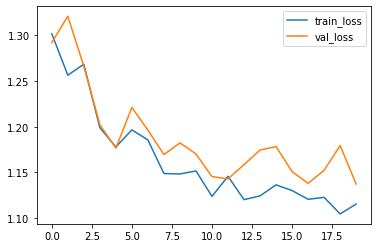

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

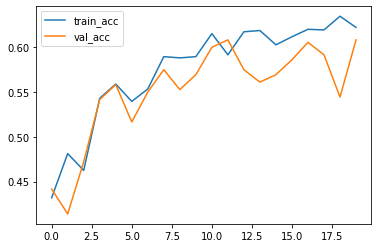

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_acc, label='train_acc')
plt.plot(validation_acc,label='val_acc')
plt.legend()
plt.show

In [ ]:
train_loss_2, train_acc_2, validation_loss_2, validation_acc_2 = train(model, device, train_dl, val_dl, 20)


  0%|          | 0/20 [00:00<?, ?epoch/s]

<ipython-input-74-f45c6707ebdb>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.max_pool2d(x, kernel_size=2)
<ipython-input-74-f45c6707ebdb>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.max_pool2d(x, kernel_size=2)
<ipython-input-74-f45c6707ebdb>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.conv5(x)
<ipython-input-74-f45c6707ebdb>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.batchnorm1(x)
<ipython-input-74-f45c6707ebdb>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.conv1(x)
<ipython-input-74-f45c6707ebdb>:25: UserWarning: Implicit dimension choice f

<ipython-input-28-cef92a3fcf47>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.max_pool2d(x, kernel_size=2)
<ipython-input-28-cef92a3fcf47>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
<ipython-input-28-cef92a3fcf47>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
<ipython-input-28-cef92a3fcf47>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.conv2(x)
<ipython-input-28-cef92a3fcf47>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.max_pool2d(x, kernel_size=2)
<ipython-input-28-cef92a3fcf47>:42: UserWarning: Implicit dimension choice for soft

<AxesSubplot:>

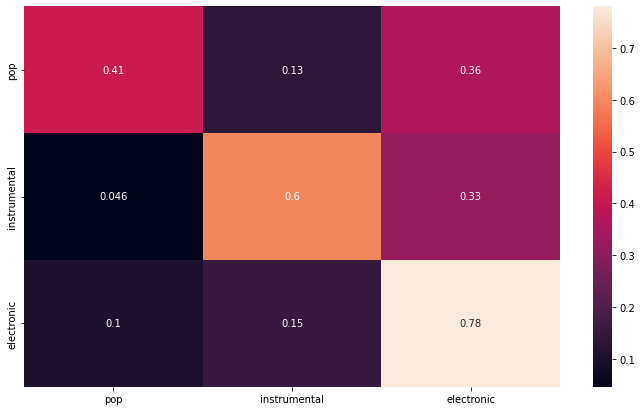

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_dl:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('pop','instrumental','electronic')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)


<function matplotlib.pyplot.show(close=None, block=None)>

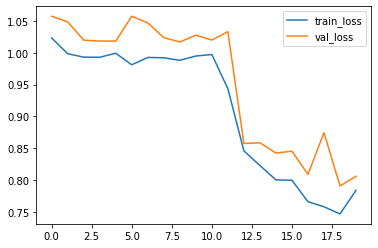

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_loss_2, label='train_loss')
plt.plot(validation_loss_2,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

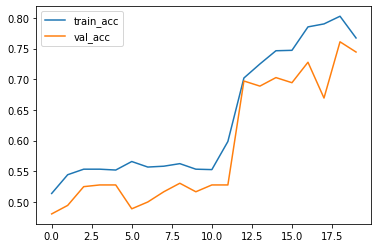

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_acc_2, label='train_acc')
plt.plot(validation_acc_2,label='val_acc')
plt.legend()
plt.show

<ipython-input-74-f45c6707ebdb>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.max_pool2d(x, kernel_size=2)
<ipython-input-74-f45c6707ebdb>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
<ipython-input-74-f45c6707ebdb>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
<ipython-input-74-f45c6707ebdb>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
<ipython-input-74-f45c6707ebdb>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
<ipython-input-74-f45c6707ebdb>:37: UserWarning: Implicit dimension choice for softmax has been deprec

<AxesSubplot:>

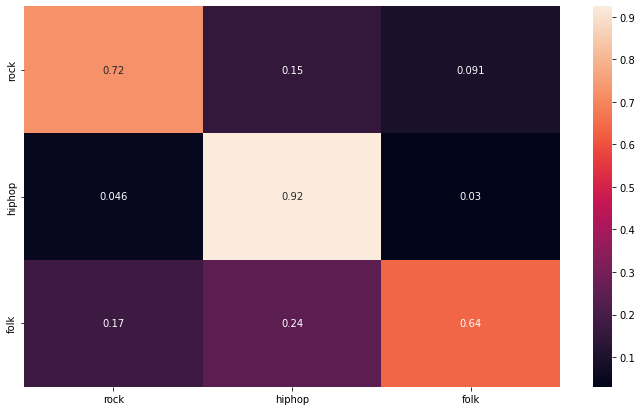

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_dl:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('rock','hiphop','folk')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
music_model = music_net()
torch.save(music_model.state_dict(), '/content/drive/MyDrive/CNNModelWeights.pth')


**Making Prediction**

In [ ]:
song= '/content/gdrive/MyDrive/Data/youtube_test/onlymp3.to - Eminem - Rap God (Explicit)-XbGs_qK2PQA-256k-1654041745772 (2).mp3'
x, sr = librosa.load(song, sr=None, mono=True, duration = 3)
print('Duration: {:.2f}s'.format(x.shape[-1] / sr))

start, end = 0,3
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

Duration: 3.00s


In [ ]:
file_dict = "/content/gdrive/MyDrive/Data/youtube_test/"
files_os = os.listdir(file_dict)

files_mp3 = []
for file_path in files_os:
    files_mp3.append(os.path.basename(file_path))

# convert mp3 file to wav file
for root, dirs, files_os in os.walk(file_dict):
    for file in files_os:  
        for i in range(0,len(files_mp3)):
          if file == files_mp3[i]:
            name, ext = os.path.splitext(file)
            filepath = os.path.join(root, file)
            try:
                t1 = 0
                t2 = 3 * 1000
                sound = AudioSegment.from_mp3(filepath)
                new = sound[t1:t2]
                new.export("/content/gdrive/MyDrive/Data/youtube_wav/{0}.wav".format(name), format="wav")
            except Exception as e:
                print(f"Error processing file: {filepath}. {e}")
                continue

Saving spectrogram: /content/gdrive/MyDrive/Data/youtube_spec/yt_3.png


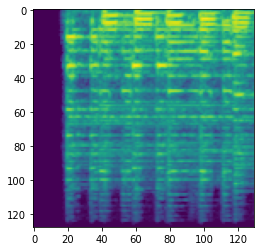

In [ ]:
#Taking a song that is not in the training file

song ='/content/gdrive/MyDrive/Data/youtube_wav/onlymp3.to - Tarantella Napoletana-U-xsosv6uM0-256k-1654338676215 (2).wav'
y, sr = librosa.load(song, duration=3)
mels = librosa.feature.melspectrogram(y=y, sr=sr)
fig = plt.Figure()
canvas = FigureCanvasAgg(fig)
p = plt.imshow(librosa.power_to_db(mels, ref=np.max))
print(f'Saving spectrogram: /content/gdrive/MyDrive/Data/youtube_spec/yt_3.png')

if COLAB:
    plt.savefig(
        f'/content/gdrive/MyDrive/Data/youtube_spec/yt_3.png')
else:
    plt.savefig(f'./content/gdrive/MyDrive/Data/youtube_spec/yt_3.png')

In [ ]:
from torchvision.transforms import ToTensor
from PIL import Image
def predict(image_data, model):
    img = Image.open(image_data)
    img = img.convert('RGB')
    transform_norm = transforms.Compose([transforms.ToTensor(), transforms.Resize((288,432))])
    img_normalized = transform_norm(img).float()
    img_normalized = img_normalized.unsqueeze_(0)
    # input = Variable(image_tensor)
    # print(img_normalized.shape)
    with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
     # print(output)
      index = output.data.cpu().numpy().argmax()
      classes = train_data.classes
      class_name = classes[index]
      return class_name

In [ ]:
predict_class = predict('/content/gdrive/MyDrive/Data/youtube_spec/yt_3.png',model)
print(predict_class)

folk


<ipython-input-13-f45c6707ebdb>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
